In [2]:
import nomic
from nomic import embed
import pandas as pd
import numpy as np
import os
import io
import uuid
import matplotlib.pyplot as plt

from datasets import load_dataset

import base64
import re
import ollama
from ollama import chat
from langchain_experimental.graph_transformers.llm import LLMGraphTransformer

from langchain_ollama.llms import OllamaLLM

from langchain_community.graphs import Neo4jGraph
from langchain_community.graphs.graph_document import GraphDocument, Node, Relationship

from langchain_core.documents import Document


from neo4j import GraphDatabase

from yfiles_jupyter_graphs_for_neo4j import Neo4jGraphWidget



In [3]:
NEO4J_SERVER_URL = "bolt://localhost:7687"
NEO4J_DB_NAME= "ragdb"
NEO4J_LOGIN = os.environ['NEO4J_USER_LOGIN']
NEO4J_PWD = os.environ['NEO4J_USER_PWD']

In [4]:
TEXT_EMBEDDING_MODEL = 'DC1LEX/nomic-embed-text-v1.5-multimodal'
VISION_EMBEDDING_MODEL = 'nomic-embed-vision-v1.5'
MULTIMODAL_INFERENCE_MODEL = "gemma3:4b"
MULTIMODAL_LLAVA_MODEL = "llava:7b"

In [5]:
RAG_DATA_FILENAME = "rag_data.csv"
RAG_DATA_IMG_COL_NAME = "image_filename"
RAG_DATA_DOC_COL_NAME = "doc"
RAG_IMG_FOLDER = "images"
RAG_MAX_GRAPH_DEPTH = 2
RAG_QUERY_NUM_TOP_RESULTS = 6
USER_QUERY_IMAGE_SEARCH_FOLDER = "user_image_search"

In [6]:
BENCH_DATA_IMG_COL_NAME = "image"
BENCH_DATA_GT_IMG_COL_NAME = "gt_images"
BENCH_DATA_QUESTION_COL_NAME = "question"
BENCH_DATA_CHOICE_A_COL_NAME = "A"
BENCH_DATA_CHOICE_B_COL_NAME = "B"
BENCH_DATA_CHOICE_C_COL_NAME = "C"
BENCH_DATA_CHOICE_D_COL_NAME = "D"
BENCH_DATA_ANSWER_CHOICE_COL_NAME = "answer_choice"
BENCH_DATA_ANSWER_TEXT_COL_NAME = "answer"
BENCH_DATA_BASE_SUBSET_SIZE = 10

In [7]:
ollama.pull(TEXT_EMBEDDING_MODEL)
ollama.pull(MULTIMODAL_INFERENCE_MODEL)
ollama.pull(MULTIMODAL_LLAVA_MODEL)

ProgressResponse(status='success', completed=None, total=None, digest=None)

In [8]:
def get_rag_img_path(filename):
    local_path = os.path.join(RAG_IMG_FOLDER,filename)
    if os.path.isfile(local_path):
        return local_path
    else :
        print(f"File {local_path} does not exist or is not a file.")

In [9]:
def get_user_img_search_path(filename):
    local_path = f"{USER_QUERY_IMAGE_SEARCH_FOLDER}/{filename}"
    if os.path.isfile(local_path):
        return local_path
    else :
        print(f"File {local_path} does not exist or is not a file.")

In [10]:
def encode_image(img_path):
    encoded_image = None

    with open(img_path, "rb") as f:
        encoded_image = base64.b64encode(f.read()).decode("utf-8")
    
    return encoded_image

def encode_images(img_paths):
    return [encode_image(img_path) for img_path in img_paths]

In [11]:
def save_img_to_folder(folder,image_data):
    img_name = f"{uuid.uuid4()}.png"
            
    img_path = os.path.join(folder, img_name)
    
    image_data.save(img_path)

    return img_path

In [12]:
def format_query_question(base_question, option_a, option_b, option_c, option_d):
    return f"""{base_question}.
    Simply state the answer you choose among the following options :
    - {option_a}
    - {option_b}
    - {option_c}
    - {option_d}"""

In [13]:
def get_img_embedding(img_path):
    nomic_api_key = os.environ['NOMIC_API_KEY'] 

    nomic.login(nomic_api_key)

    output = embed.image(
        images=[img_path
        ],
        model=VISION_EMBEDDING_MODEL,
    )

    #print(output['usage'])
    img_embeddings = np.array(output['embeddings'])
    #print(img_embeddings)
    #print(img_embeddings.shape)
    
    return img_embeddings[0]


In [14]:
def get_text_embedding(txt):
    response = ollama.embed(model=TEXT_EMBEDDING_MODEL, input=txt)
    txt_embedding = response["embeddings"]
    return txt_embedding[0]

In [15]:
def get_node_from_text_prop(graph_doc, txt):
    #result = None
    for node in graph_doc.nodes:
        txt_value = node.properties.get("text")
        if txt_value is not None and txt_value == txt:
            return node
    return None
            

In [16]:
def main_mllm_txt_search(txt_search, ctx):
    response = chat(
        model=MULTIMODAL_INFERENCE_MODEL,
        messages=[
            {
                "role": "user",
                "content": f"Answer the question while taking into account the context. \n question:{txt_search} \n context:{ctx}",
                #"images":[img_b64]
            }
        ]
        
    )

    result = response['message']['content']
    return result

In [17]:
def get_query_mllm_img_desc(instruction, file_path):
    try:
        # Ensure the image exists and is accessible
        with open(file_path, 'rb') as f:
            image_data = f.read()

        result = ollama.generate(
            model=MULTIMODAL_LLAVA_MODEL,
            prompt=instruction,
            images=[image_data], # Pass image data directly
            stream=False
        )
        #print(result['response'])
        return result['response']
    except FileNotFoundError:
        print(f"Error: Image file not found at {file_path}")
    except Exception as e:
        print(f"An error occurred: {e}")



In [18]:
def get_node_text(node):
    node_txt = node.get("text")
    if node_txt is not None :
        return node_txt
    else:
        return node.get("id")


In [19]:
def format_context_for_rag(neo4j_results):
    context_list = []
    for record in neo4j_results:
        # Extract relevant information from the record
        source_entity = record["a"]
        relationships = record["r"]

        # Format the extracted information into a string or structured data
        # suitable for your RAG model

        relationships_txt_list = [f" {relationship.type} {get_node_text(relationship.nodes[0])}" for relationship in relationships]
        context_string = f"{get_node_text(source_entity)} {" ".join(relationships_txt_list)}"

        #print(f"Context string : {context_string}")
        
        context_list.append(context_string)
    return "\n".join(context_list)

In [20]:
def temp_copy_graph_query_result(session, record):
    
    for value in record.values():
        # If it's a node

        if hasattr(value, 'labels'):
            props = ", ".join(f"{k}: {repr(v)}" for k, v in dict(value).items())
            node_query = f"""
                MERGE (n:TempViz:{re.sub(r"\s+", "_", list(value.labels)[0])} {{element_id:"{value.element_id}"}})
                SET n += {{{props}}}
            """
            session.run(node_query)

            
    
    for value in record.values():
        # If it's a relationship
        if hasattr(value, 'type'):
            start_id = value.nodes[0].element_id
            end_id = value.nodes[1].element_id
            #print("simple relationship")
            props = ", ".join(f"{k}: {repr(v)}" for k, v in dict(value).items())
            rel_query = f"""
                MATCH (a:TempViz {{element_id:"{start_id}"}}), (b:TempViz {{element_id:"{end_id}"}})
                MERGE (a)-[r:{value.type}]->(b)
                SET r += {{{props}}}
            """
            session.run(rel_query)

    
    for value in record.values():
        # If it's a list of relationships
        if isinstance(value, list):
            #print("list relationship")
            #print(f"Rels : {value}")
            for rel in value:
                
                start_id = rel.nodes[0].element_id
                end_id = rel.nodes[1].element_id
                #print(f"Rel : {rel}")
                #print(f"Rel start id : {start_id}")
                #print(f"Rel end id : {end_id}")
                props = ", ".join(f"{k}: {repr(v)}" for k, v in dict(rel).items())
                rel_query = f"""
                    MATCH (a:TempViz {{element_id:"{start_id}"}}), (b:TempViz {{element_id:"{end_id}"}})
                    MERGE (a)-[r:{rel.type}]->(b)
                    SET r += {{{props}}}
                """
                session.run(rel_query)

In [21]:
def visualize_result_with_yfiles(result):
    """
    Push nodes/relationships from a neo4j.Result to a temporary in-memory graph
    and display them with Neo4jGraphWidget.
    """
    driver = GraphDatabase.driver(uri=NEO4J_SERVER_URL, database=NEO4J_DB_NAME, auth=(NEO4J_LOGIN,NEO4J_PWD))
    with driver.session() as session:
        # Clear a temporary namespace (label:TempViz)
        session.run("MATCH (n:TempViz) DETACH DELETE n")
        
        for record in result:
            #print(f"Record : {record}")
            temp_copy_graph_query_result(session, record)

    # Now visualize just the TempViz graph
    widget = Neo4jGraphWidget(driver)
    widget.show_cypher("""
        MATCH (n:TempViz)-[r]->(m:TempViz)
        RETURN n, r, m
    """,layout="hierarchic")
    driver.close()

In [22]:
def visualize_all_graph_with_yfiles():
    driver = GraphDatabase.driver(uri=NEO4J_SERVER_URL, database=NEO4J_DB_NAME, auth=(NEO4J_LOGIN,NEO4J_PWD))  
    neo4j_subgraph=Neo4jGraphWidget(driver)

    neo4j_subgraph.show_cypher("MATCH (s)-[r]->(t) RETURN s,r,t LIMIT 40", layout="hierarchic")
    driver.close()

    

In [23]:
def get_main_mllm_img_desc(img_path):
    img_b64 = encode_image(img_path)
    response = chat(
        model=MULTIMODAL_INFERENCE_MODEL,
        messages=[
            {
                "role": "user",
                "content": "Describe all people, organizations, and events in this image.",
                "images":[img_b64]
            }
        ]
        
    )

    image_description = response['message']['content']
    return image_description

In [24]:
def main_mllm_img_with_query_search(img_path, query):
    img_b64 = encode_image(img_path)
    response = chat(
        model=MULTIMODAL_INFERENCE_MODEL,
        messages=[
            {
                "role": "user",
                "content": query,
                "images":[img_b64]
            }
        ]
        
    )

    result = response['message']['content']
    return result

In [25]:
# Function to run a Cypher query
def run_query(query, parameters=None):
    # Create a driver instance
    driver = GraphDatabase.driver(uri=NEO4J_SERVER_URL, database=NEO4J_DB_NAME, auth=(NEO4J_LOGIN,NEO4J_PWD))
    tobereturned = []
    with driver.session() as session:
        result = session.run(query, parameters or {})
        tobereturned =  [record for record in result]
    driver.close()
    return tobereturned

In [26]:
def search_from_txt_with_rag_context(search, max_graph_depth=1, num_top_results=3):
    
    # Get RAG context
    query = f"""
    MATCH (a)-[r*1..{max_graph_depth}]->(b)
    WITH a, b, gds.similarity.cosine(a.embedding, $query_embeddings) AS similarity, r
    ORDER BY similarity DESC
    LIMIT $top_k
    RETURN a, r, b
    """

    params = {"query_embeddings": get_text_embedding(search), "top_k":num_top_results}
    rag_subgraph = run_query(query, params)

    # Print results
    #for record in results:
        #print(record)
    # Format RAG context
    search_ctx = format_context_for_rag(rag_subgraph)

    # Query llm with rag context
    return main_mllm_txt_search(search,search_ctx), rag_subgraph

In [27]:
def search_query_mllm_from_img_with_rag_context(img_path, max_graph_depth=1, num_top_results=3):
    
    instruction = "What is depicted in this image ?"
    img_txt = get_query_mllm_img_desc(instruction, img_path)
    #print("Image search")
    return search_from_txt_with_rag_context(img_txt, max_graph_depth, num_top_results)

In [28]:
def search_main_mllm_from_img_with_query_and_rag_context(img_path, user_query, max_graph_depth=1, num_top_results=3):
    
    # Get RAG context
    query = f"""
    MATCH (a)-[r*1..{max_graph_depth}]->(b)
    WITH a, b, gds.similarity.cosine(a.embedding, $query_embeddings) AS similarity, r
    ORDER BY similarity DESC
    LIMIT $top_k
    RETURN a, r, b
    """

    params = {"query_embeddings": get_img_embedding(img_path), "top_k":num_top_results}
    rag_subgraph = run_query(query, params)

    # Print results
    #for record in results:
        #print(record)
    # Format RAG context with initial user query
    search_ctx = f"""question : {user_query}
                    context from image : {format_context_for_rag(rag_subgraph)}"""
    
    # Query llm with rag context
    return main_mllm_img_with_query_search(img_path,search_ctx), rag_subgraph

In [29]:
def preprocess_data(text_docs, img_data):
    
    # Preprocess textual data
    docs = [Document(page_content=txt, metadata={"embedding":get_text_embedding(txt)}) for txt in text_docs[RAG_DATA_DOC_COL_NAME]]


    img_docs = [Document(page_content=img_desc, metadata={"url": get_rag_img_path(img_name), "embedding":get_text_embedding(img_desc)}) 
                for img_desc, img_name in zip(img_data[RAG_DATA_DOC_COL_NAME], img_data[RAG_DATA_IMG_COL_NAME])]

    
    # Gather all preprocessed data
    docs.extend(img_docs)

    return docs

In [30]:
def preprocess_benchmark_data(img_data):
    
    # Preprocess textual data
    #docs = [Document(page_content=txt, metadata={"embedding":get_text_embedding(txt)}) for txt in text_docs[RAG_DATA_DOC_COL_NAME]]
    img_docs = []
    rec_num = 1
    for imgs in img_data:
        print(f"Record num : {rec_num}")
        print(f"Num ground truth images : {len(imgs)}")
        #There are 5 ground truth images, but we limit to 3 for the sake of computation limitation
        for img in imgs[:3]:
            
            img_path = save_img_to_folder(RAG_IMG_FOLDER, img)            
 
            img_desc = get_main_mllm_img_desc(img_path)
            img_docs.append(Document(page_content=img_desc, metadata={"url": img_path, "embedding":get_text_embedding(img_desc)}))
        
        rec_num += 1
    

    
    # Gather all preprocessed data
    #docs.extend(img_docs)

    return img_docs

In [31]:
def extracted_graph_post_treatment(graph_docs):
    
    # Add embeddings to the nodes of the graph
    for graph_doc in graph_docs:
        
        for node in graph_doc.nodes:
            node_text = node.properties.get("text")
            if node_text is not None :
                node.properties["embedding"] = get_text_embedding(node_text)
            else : 
                node_id = node.id
                if node_id is not None :
                    node.properties["embedding"] = get_text_embedding(node_id)

                
    # Add Image nodes with properties like embedding then relate to the rest of the graph
    img_id = 0

    for graph_doc in graph_docs:
        # If the source of the graphDoc is the description of an image
        graph_source = graph_doc.source
        img_url = graph_source.metadata.get("url") 
        
        if img_url is not None:   
            #print(img_url) 
            # Créer un noeud image avec l'URL en question et l'embedding de l'image
            img_node = Node(id=f"img_{uuid.uuid4()}", type="Image", properties={"url": img_url, "embedding":get_img_embedding(img_url)})   
            
            new_relationships = []

            # Lier l'image à tous les noeuds du grapheDoc
            for node in graph_doc.nodes:
                new_relationships.append(Relationship(source=img_node,target=node, type="contains"))
            
            graph_doc.nodes.append(img_node)
            graph_doc.relationships.extend(new_relationships)
            img_id += 1

    return graph_docs

In [32]:
def populate_neo4j_graph():
    
    
    raw_data_df = pd.read_csv(RAG_DATA_FILENAME,sep=",")

    # Preprocess all data
    docs = preprocess_data(raw_data_df[raw_data_df[RAG_DATA_IMG_COL_NAME].isna()], raw_data_df[ raw_data_df[RAG_DATA_IMG_COL_NAME].notna()])

    # Normal Ollama LLM for graph extraction
    llm = OllamaLLM(model=MULTIMODAL_INFERENCE_MODEL, temperature=0.0)

    transformer = LLMGraphTransformer(
        llm=llm,
        #allowed_nodes=["Person", "Organization", "Event"],
        #node_properties=True
    )
    
    # 3. Extract graph
    graph_docs = transformer.convert_to_graph_documents(docs)
    graph_docs = extracted_graph_post_treatment(graph_docs)

    #Empty graph 
    driver = GraphDatabase.driver(uri=NEO4J_SERVER_URL, database=NEO4J_DB_NAME, auth=(NEO4J_LOGIN,NEO4J_PWD))
    with driver.session() as session:

        session.run("MATCH (n) DETACH DELETE n")
    driver.close()
    
    # Store Knowledge Graph in Neo4j
    graph_store = Neo4jGraph(url=NEO4J_SERVER_URL, username=NEO4J_LOGIN, password=NEO4J_PWD, database=NEO4J_DB_NAME)
    #graph_store.write_graph(graph_docs)

    graph_store.add_graph_documents(graph_docs, include_source=True)

In [33]:


def populate_neo4j_graph_from_benchmark_ds(ds):    
    
    raw_data_df = ds

    # Preprocess all data
    docs = preprocess_benchmark_data(raw_data_df[BENCH_DATA_GT_IMG_COL_NAME])

    # Normal Ollama LLM for graph extraction
    llm = OllamaLLM(model=MULTIMODAL_INFERENCE_MODEL, temperature=0.0)

    transformer = LLMGraphTransformer(
        llm=llm,
        #allowed_nodes=["Person", "Organization", "Event"],
        #node_properties=True
    )
    
    # 3. Extract graph
    graph_docs = transformer.convert_to_graph_documents(docs)
    graph_docs = extracted_graph_post_treatment(graph_docs)

        
    # Store Knowledge Graph in Neo4j
    graph_store = Neo4jGraph(url=NEO4J_SERVER_URL, username=NEO4J_LOGIN, password=NEO4J_PWD, database=NEO4J_DB_NAME)


    graph_store.add_graph_documents(graph_docs, include_source=True)

    graph_store._driver.close()

In [34]:
if __name__ == "__main__":  
    
    ds = load_dataset("uclanlp/MRAG-Bench")
    #populate_neo4j_graph()
   


Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

In [35]:
#Empty graph 
"""
driver = GraphDatabase.driver(uri=NEO4J_SERVER_URL, database=NEO4J_DB_NAME, auth=(NEO4J_LOGIN,NEO4J_PWD))
with driver.session() as session:

    session.run("MATCH (n) DETACH DELETE n")
driver.close()

for i in range(BENCH_DATA_BASE_SUBSET_SIZE):
    #View top data 
    subset = ds["test"].select([i])

    print(subset)


    populate_neo4j_graph_from_benchmark_ds(subset)
     
    """


'\ndriver = GraphDatabase.driver(uri=NEO4J_SERVER_URL, database=NEO4J_DB_NAME, auth=(NEO4J_LOGIN,NEO4J_PWD))\nwith driver.session() as session:\n\n    session.run("MATCH (n) DETACH DELETE n")\ndriver.close()\n\nfor i in range(BENCH_DATA_BASE_SUBSET_SIZE):\n    #View top data \n    subset = ds["test"].select([i])\n\n    print(subset)\n\n\n    populate_neo4j_graph_from_benchmark_ds(subset)\n\n    '

## Requête incluant le RAG

In [ ]:
if __name__ == "__main__":
    simple_search_results = []
    rag_1_search_results = []
    rag_2_search_results = []
    rag_3_search_results = []

    subset = ds["test"].select(range(BENCH_DATA_BASE_SUBSET_SIZE))

    for record in subset:
        query_img = record[BENCH_DATA_IMG_COL_NAME]
        base_question = record[BENCH_DATA_QUESTION_COL_NAME]
        option_a = record[BENCH_DATA_CHOICE_A_COL_NAME]
        option_b = record[BENCH_DATA_CHOICE_B_COL_NAME]
        option_c = record[BENCH_DATA_CHOICE_C_COL_NAME]
        option_d = record[BENCH_DATA_CHOICE_D_COL_NAME]
        right_answer = record[BENCH_DATA_ANSWER_TEXT_COL_NAME]

        query_question = format_query_question(base_question,option_a,option_b,option_c,option_d)
        query_img_path = save_img_to_folder(USER_QUERY_IMAGE_SEARCH_FOLDER,query_img)

        simple_search = main_mllm_img_with_query_search(query_img_path,query_question)
        rag_1_search, img_rag_1_subgraph = search_main_mllm_from_img_with_query_and_rag_context(query_img_path, query_question, max_graph_depth=1, num_top_results=RAG_QUERY_NUM_TOP_RESULTS)
        rag_2_search, img_rag_2_subgraph = search_main_mllm_from_img_with_query_and_rag_context(query_img_path, query_question, max_graph_depth=2, num_top_results=RAG_QUERY_NUM_TOP_RESULTS)
        rag_3_search, img_rag_3_subgraph = search_main_mllm_from_img_with_query_and_rag_context(query_img_path, query_question, max_graph_depth=3, num_top_results=RAG_QUERY_NUM_TOP_RESULTS)

        print(simple_search)
        print(rag_1_search)
        print(rag_2_search)
        print(rag_3_search)

        simple_search_results.append(simple_search == right_answer)
        rag_1_search_results.append(rag_1_search == right_answer)
        rag_2_search_results.append(rag_2_search == right_answer)
        rag_3_search_results.append(rag_3_search == right_answer)
    
    global_search_results = [simple_search_results,rag_1_search_results,rag_2_search_results,rag_3_search_results]

    global_num_good_answers = [sum(answers) for answers in global_search_results]


Cairn_terrier
Cairn_terrier
Cairn_terrier
Cairn_terrier
capuchin
capuchin
capuchin
capuchin
New York City
New York City
New York City
New York City
**1.8L turbocharged inline-4** 

This Audi A4 model typically came with a 1.8-liter turbocharged inline-4 engine.
- 2.0L turbocharged inline-4
- 2.0L turbocharged inline-4
- 2.0L turbocharged inline-4
Versailles
Versailles
Versailles
Versailles
Isle of Man
Isle of Man
Isle of Man
Isle of Man
A blueish-green mold forms on its surface.
Its skin remains smooth and shiny.
Its skin remains smooth and shiny.
Its skin remains smooth and shiny.
impala
impala
impala
topi
macaque
macaque
macaque
macaque
Siberian_husky
Siberian_husky
Siberian_husky
Siberian_husky


AttributeError: 'list' object has no attribute 'sum'

In [51]:
print([elem for elem in subset[BENCH_DATA_ANSWER_TEXT_COL_NAME]])

['silky_terrier', 'capuchin', 'New York City', '2.0L turbocharged inline-4', 'Versailles', 'Isle of Man', 'Its skin remains smooth and shiny.', 'hartebeest', 'macaque', 'Siberian_husky']


In [52]:
print([elem for elem in subset[BENCH_DATA_QUESTION_COL_NAME]])

['Can you identify this animal?', 'Can you identify what kind of animal this is?', 'In which city can the building in the picture be found?', 'Can you tell me the typical engine type for this car model and the cylinder liter size?', 'In which city is the building shown in the picture located?', 'Which country does this cat breed come from?', 'Among these features, which one is unlikely for this fruit once it undergoes oxidation?', 'Can you identify which animal this is?', 'Which animal is depicted here?', 'Can you identify which animal this is?']


In [53]:
query_question

'Can you identify which animal this is?.\n    Simply state the answer you choose among the following options :\n    - Siberian_husky\n    - Alaskan Malamute\n    - Samoyed\n    - Tamaskan'

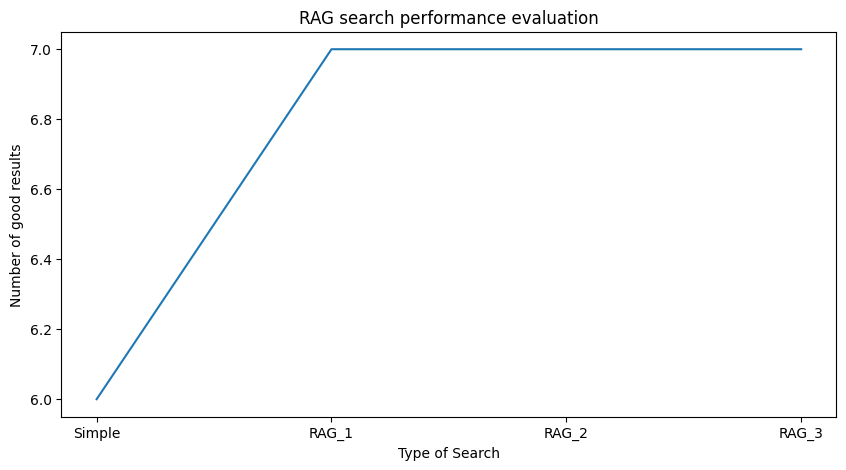

In [41]:
if __name__ == "__main__":  

    # The labels for your x-axis
    x_labels = ["Simple", "RAG_1", "RAG_2", "RAG_3"]

    # Create a numerical list for the tick locations
    x_positions = list(range(len(x_labels)))

    plt.figure(figsize=(10,5))
    plt.plot(x_positions, global_num_good_answers)
    plt.xticks(x_positions, x_labels)
    plt.xlabel("Type of Search")
    plt.ylabel("Number of good results")
    plt.title("RAG search performance evaluation")

    plt.show()

In [54]:
if __name__ == "__main__":  
    visualize_result_with_yfiles(img_rag_1_subgraph)


GraphWidget(layout=Layout(height='500px', width='100%'))

In [55]:
if __name__ == "__main__":  
    visualize_result_with_yfiles(img_rag_2_subgraph)

GraphWidget(layout=Layout(height='500px', width='100%'))

In [56]:
if __name__ == "__main__":  
    visualize_result_with_yfiles(img_rag_3_subgraph)

GraphWidget(layout=Layout(height='500px', width='100%'))

In [ ]:
if __name__ == "__main__":  
    # Query 1
    search1 = "Where does Alice work?"

    # Query 2
    search2 = "Who works for OpenWidgets?"

    search3 = "black"
    search4 = "describe happy people"

    search_result, rag_subgraph = search_from_txt_with_rag_context(search4, max_graph_depth=RAG_MAX_GRAPH_DEPTH, num_top_results=RAG_QUERY_NUM_TOP_RESULTS)
    file_path = get_user_img_search_path('Man.jpg') # Replace with the actual path to your image
    img_search_result, img_rag_subgraph = search_query_mllm_from_img_with_rag_context(file_path,max_graph_depth=RAG_MAX_GRAPH_DEPTH, num_top_results=RAG_QUERY_NUM_TOP_RESULTS)

In [ ]:
if __name__ == "__main__":  
    print(search_result)


In [ ]:
if __name__ == "__main__":  
    print(img_search_result)

In [ ]:
if __name__ == "__main__":  
    visualize_result_with_yfiles(rag_subgraph)

In [ ]:
if __name__ == "__main__":  
    visualize_result_with_yfiles(img_rag_subgraph)

In [57]:
if __name__ == "__main__":

    visualize_all_graph_with_yfiles()

GraphWidget(layout=Layout(height='770px', width='100%'))

In [ ]:
if __name__ == "__main__":
    #search_main_mllm_from_img_with_query_and_rag_context(img_path, user_query, max_graph_depth=1, num_top_results=3)